In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import rebound
import pandas as pd
import reboundx
import os
from datetime import datetime
import shutil
import ast

In [4]:
# globals
earth = 'earth'
saturn = 'saturn'
jupiter = 'jupiter'
basepath =  r''   # your preferred filepath to put all the subfolders in.
plt.style.use('dark_background')

# Some counters for results
class SubMoonCounts:
	inorbit = 0
	boundtoplanet = 0
	outofsystem = 0
	hitmainmoon = 0
	hitsubmoon = 0
	hitplanet = 0

# Planet Data

In [5]:
def planetdata(planet):
	if (str.lower(planet) == "jupiter"):
		moon = "JupiterMoon"
		planetmass = 9.54e-4
		planetdist = 5.2
		planetrad = 0.000477895
		moondist = 6.76e-3
		moonmass = 4.943e-8
		moonrad= 1.408e-5
		moonhill = 1.7e-4
		moonorbittime = 0.02
	elif (str.lower(planet) == "earth"):
		moon = "Moon"
		planetmass = 3.0027e-6
		planetdist = 1.0
		planetrad = 4.26352e-5
		moondist = 2.596e-3
		moonmass = 3.694e-8
		moonrad = 2.266e-5
		moonhill =  4.15e-4
		moonorbittime = 0.0748
	elif (str.lower(planet) == "saturn"):
		moon = "SaturnMoon"
		planetmass = 2.857e-4
		planetdist = 9.5
		planetrad = 4.0287e-4
		moondist = 8.167e-3
		moonmass = 6.76e-8
		moonrad = 1.721e-5
		moonhill = 3.5e-4
		moonorbittime = 0.0436
	else: 
		print("Planet name not valid")
		return None
	return moon, planetmass, planetdist, planetrad, moondist, moonmass, moonrad, moonhill, moonorbittime


# Plotting functions

In [6]:
def plotecc(ecc, sma, moonhill):
	eccyorig = np.array(ecc[-1])
	eccy = np.array([0 if (np.isnan(x) or x > 1 or x < 0 ) else x for x in eccyorig])
	eccfig, eccax = plt.subplots()
	eccax.ticklabel_format(style='sci')
	for i in range(len(eccy)):
		if np.isnan(eccyorig[i]):
			marker = "x"
			color = 'green'
		elif eccyorig[i] < 0 or eccyorig[i] > 1:
			marker = "p"
			color = 'magenta'
		else:
			color = 'white'
			marker = '.'
		eccax.set_xlabel("Initial SMA")
		eccax.set_ylabel("Final ecc")
		eccax.scatter(sma[0][i]/moonhill, eccy[i], color=color, marker=marker)
	return eccfig


In [7]:
def plotperidist(ecc, sma, moonhill):
	
	peridistorig = [sma[0][i]*(1-ecc[0][i]) for i in range(len(sma[0]))]
	peridistfinal = [0 if np.isnan(i) else sma[-1][i]*(1-ecc[-1][i]) for i in range(len(sma[-1]))]
	peridistfig, peridistax = plt.subplots()
	peridistax.ticklabel_format(style='sci')
	peridistax.set_xlabel("Initial Pericenter Distance")
	peridistax.set_ylabel("Final Pericenter Distance")
	for i in range(len(peridistorig)):
		if peridistfinal[i] == 0:
			color = 'green'
			marker = 'x'
		else:
			color = 'white'
			marker = '.'
		peridistax.scatter(peridistorig[i]/moonhill, peridistfinal[i]/moonhill, color=color, marker=marker)
	return peridistfig


In [8]:
def plotsma(sma, moonhill):
	smax = np.array(sma[0])
	smayorig = np.array(sma[-1])
	smay = np.array([0 if (np.isnan(smayorig[x])) else 0.03*moonhill if (smayorig[x] < 0) else 0.05*moonhill if (0.5*smax[x] > smayorig[x] or smayorig[x] > 1.5*smax[x]) else smayorig[x] for x in range(len(smayorig))])


	smafig, smaax = plt.subplots()
	pointofnoreturn = 0
	smaax.ticklabel_format(style='sci')
	smaax.axline((0,0), slope=1, color = 'tab:cyan', zorder=-2, label="1:1")
	for i in range(len(smayorig)):
		j=np.flip(smayorig)[i]
		if (j > 0 and not(0.8*smax[i] > smayorig[i] or smayorig[i] > 1.2*smax[i])):
			pointofnoreturn = smax[-i]/moonhill
			break
	smaax.axvline(pointofnoreturn, color='orangered', zorder=-2, label="Stable Orbit Boundary")
	for i in range(len(smax)):
		if np.isnan(smayorig[i]):
			marker = "x"
			color = 'green'
			label = 'Collided'
		elif smayorig[i] < 0:
			marker = "p"
			color = 'magenta'
			label = 'Unbound (Hyperbolic)'
		elif (0.5*smax[i] > smayorig[i] or smayorig[i] > 1.5*smax[i]):
			marker = "d"
			color = 'yellow'
			label = 'Unbound (Too far away)'
		else:
			color = 'white'
			marker = '.'
			label = 'Stable'
			SubMoonCounts.inorbit+=1
		smaax.set_xlabel("Initial sma (Hill Radii)")
		smaax.set_ylabel("Final sma (Hill Radii)")
		smaax.scatter(smax[i]/moonhill, smay[i]/moonhill, color=color, marker=marker, label=label)
		smaax.legend()
	return smafig, pointofnoreturn


# The Main Function

In [9]:
def stabilityfinder(planet, numberofsubmoons, ecc=0, inc=0, basepath=basepath):
	paramvals = locals()
	moon, planetmass, planetdist, planetrad, moondist, moonmass, moonrad, moonhill, moontime = planetdata(planet) # initial system data
	# do not proceed if planet is wrong


	# ---------- SUBFOLDER SETUP ---------- #
	subfoldername = str(datetime.now().isoformat(sep= ' ', timespec='seconds'))
	subfolderpath = os.path.join(basepath, subfoldername)
	if os.path.exists(subfolderpath):
		shutil.rmtree(subfolderpath)
	os.mkdir(subfolderpath)

	# ---------- SETUP SIM ---------- #
	sim = rebound.Simulation()
	sim.units = ('yr', 'AU', 'Msun') 
	ps = sim.particles
	upperbounds = 3*moondist
	sim.configure_box(upperbounds+planetdist)   # confine the simulation to a box of size 10
	sim.boundary = "open"

	# ---------- SETUP PARTICLES ----------#
	sim.G = 4*(math.pi)**2
	sim.add(m=planetmass, hash=str(planet), r=planetrad)
	sim.add(a=moondist, hash=moon, m=moonmass, r=moonrad, primary=ps[0])
	sim.move_to_com
	sim.integrator = "Mercurius"
	
	# - The janky collision logger - #
	def collision_print_only(sim_pointer, collision):
		sim = sim_pointer.contents
		mainmoonhash = str(sim.particles[1].hash)
		planethash = str(sim.particles[0].hash)
		p1 = str(sim.particles[collision.p1].hash)
		p2 = str(sim.particles[collision.p2].hash)
		crashlog = open(os.path.join(subfolderpath, "crashlog.txt"), "a+")
		print(sim.t, p1, p2, mainmoonhash, planethash, flush=True, file=crashlog)

		if (planethash == p1 or mainmoonhash == p1):
			return 2
		elif planethash == p2 or mainmoonhash == p2:
			return 1
		else:
			SubMoonCounts.hitsubmoon+=1
			return 3
		
	
	sim.collision = "direct"
	sim.collision_resolve = collision_print_only


	# --- Setup Submoons --- #
	submoondist = np.linspace(moonrad*2, moonhill, int(numberofsubmoons))
	smperi = np.random.uniform(0, math.tau, int(numberofsubmoons))
	smlongnode = np.random.uniform(0, math.tau, int(numberofsubmoons))
	smtanom = np.random.uniform(0, math.tau, int(numberofsubmoons))

	for i in range(int(numberofsubmoons)):
		submoon = "Submoon{}".format(i)
		sim.add(a=submoondist[i], e=ecc, inc=inc, omega=smperi[i], Omega=smlongnode[i], f=smtanom[i], hash=submoon, primary=ps[1])

	# ---------- OUTPUT INITIAL CONDITIONS AND PARAMETERS ---------- #
	parampath = os.path.join(subfolderpath, 'parameters.txt')
	params = open(parampath, 'w+')
	print(paramvals, file=params, flush=True)

	conditionnames = ["SMA", "sma", "inc", "LongNode", "argPeri", "trueAnom"]
	initcond = pd.DataFrame(columns=conditionnames)
	for i in range(2, 2+numberofsubmoons):
		o = ps[i].calculate_orbit(primary=ps[1])
		initconds = [o.a, o.e, o.inc, o.Omega, o.omega, o.f]
		initcond.loc[i-2] = initconds	
	condfilename = os.path.join(subfolderpath, "Initial Conditions.csv")
	initcond.to_csv(condfilename, sep='\t', header=conditionnames, index_label= 'SubMoon')

	# ---------- SETUP TRACKED VARS ----------#
	times = np.arange(0, 300*moontime, 0.5) # run for 300 orbital periods of the main moon
	submooncols = ["Submoon{}".format(i) for i in range(numberofsubmoons)]
	inc = np.zeros((len(times), numberofsubmoons))
	ecc = np.zeros((len(times), numberofsubmoons))
	sma = np.zeros((len(times), numberofsubmoons))
	submoonhashes = [ps[submoonnum].hash for submoonnum in submooncols]
	hashlist = open(os.path.join(subfolderpath, "hashlist.txt"), "w+")
	print(list(zip(submooncols, submoonhashes)), file=hashlist, flush=True)
	trackedvars = np.zeros(3)


	# ---------- START INTEGRATING ----------#
	for i, time in enumerate(times):
		sim.integrate(time)
		for j in range(numberofsubmoons):
			submoonhash = "Submoon{}".format(j)
			try:
				z = ps[submoonhash].calculate_orbit(primary=ps[1])
				if (z.e > 1 or z.a < 0):
					q = ps[submoonhash].calculate_orbit(primary=ps[0])
					if (q.a < 0 or q.e > 1):
						sim.remove(hash=submoonhash)
						raise(ValueError)
			except (ValueError, rebound.ParticleNotFound):
				trackedvars = [np.nan, np.nan, np.nan]
				continue
			else:
				trackedvars = [z.a, z.e, z.inc]
				continue
			finally:
				sma[i][j] = trackedvars[0]
				ecc[i][j] = trackedvars[1]
				inc[i][j] = trackedvars[2]

	# ---------- LOG FINAL OUTPUT ---------- #

	print("logging")
	pd.DataFrame(sma).to_csv(os.path.join(subfolderpath, "SMA.csv"), sep = '\t', header = submooncols, index_label = 'Time', na_rep='NaN')
	pd.DataFrame(ecc).to_csv(os.path.join(subfolderpath, "ecc.csv"), sep='\t', header=submooncols, index_label='Time',  na_rep='NaN')
	pd.DataFrame(inc).to_csv(os.path.join(subfolderpath, "inc.csv"), sep = '\t', header = submooncols, index_label = 'Time',  na_rep='NaN')
	print(pnr, file=params, flush=True)
	print("done")

# The Data Setup

In [8]:
eccinputs = [0, 0.3, 0.5, 0.7, 0.99]
planetinputs = [(earth, 75), (jupiter, 75), (saturn, 75)]
incinputs = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
thisdic = {"(": "", ")": "", "'": ""}
inputpath = r'' # make a file with all input combinations
# change the incinputs values and eccinputs values if you want 

inputfile = open(inputpath, "w+")
for i in planetinputs:
	for j in eccinputs:
		for k in incinputs:
			y = "{}, {}, {}".format(str(i), j, k)
			for q, z in thisdic.items():
				y = y.replace(q,z)
			print(y, file=inputfile, flush=True)


In [9]:
inputargs = pd.read_csv(inputpath, sep=",")

In [10]:
for i in range(0, len(inputargs)):
	planet, subnum, ecc, inc = inputargs.iloc[i].values
	stabilityfinder(planet, subnum, ecc, inc)

# The Graphing 

I did the graphing separately so you dont need to rerun the data, which can take hours

In [ ]:
# just run this to graph individual simulation data 
simnames = [x[0] for x in os.walk(basepath)]
simnames.pop(0)
frhs = np.zeros(len(simnames))
ecx = np.zeros(len(simnames))
incy = np.zeros(len(simnames))
for i in range(len(simnames)):
	paramfile = os.path.join(simnames[i], 'parameters.txt')
	smafile = pd.read_csv(os.path.join(
		simnames[i], 'SMA.csv'), sep='\t').to_numpy()
	eccfile = pd.read_csv(os.path.join(
		simnames[i], 'ecc.csv'), sep='\t').to_numpy()
	incfile = pd.read_csv(
		(os.path.join(simnames[i], 'inc.csv')), sep='\t').to_numpy()

	q = pd.read_fwf(paramfile, infernrows=2, header=None)
	qq = q.drop(0)
	qq = qq.drop(columns=[1, 2, 3, 4, 5, 6])
	q = q.drop(1)
	
	paramdic = ast.literal_eval(q.to_string(index_names=False, index=False, header=False, max_rows=1))
	incconverter = {0: '0', 1.5707963267948966: "90", 0.7853981633974483: "45", 2.356194490192345: "135", 3.141592653589793: "180"}

	parametertitle = "{}, {}, {}".format(paramdic['planet'], paramdic['ecc'], incconverter[paramdic['inc']])
	newpath = os.path.join(basepath, parametertitle)
	if os.path.exists(newpath):
		shutil.rmtree(newpath)
	os.mkdir(newpath)
	

	moon, planetmass, planetdist, planetrad, moondist, moonmass, moonrad, moonhill, moontime = planetdata(paramdic['planet'])

	ecx[i] = paramdic['ecc']
	incy[i] = paramdic['inc']
	frhs[i] = qq[0]
	
	smafig, pnr = plotsma(smafile, moonhill)
	smafig.savefig(os.path.join(newpath, "smafig.jpeg"))
	eccfig = plotecc(eccfile, smafile, moonhill)
	eccfig.savefig(os.path.join(newpath, "eccfig.jpeg"))
	pdfig = plotperidist(eccfile, smafile, moonhill)
	pdfig.savefig(os.path.join(newpath, "pdfig.jpeg"))
	plt.close('all')


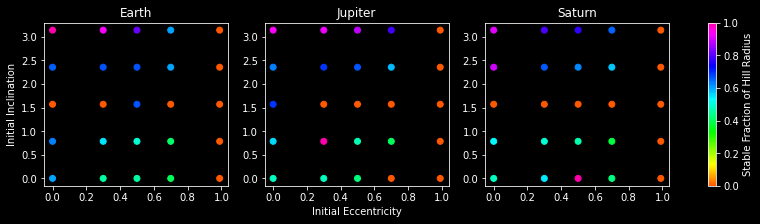

In [ ]:
# Run this to graph the overall data
fig, (ax1, ax2, ax3)= plt.subplots(1,3, figsize=(14,3))

barscale = plt.cm.hsv(np.linspace(0.06,0.9,256))
colbarcols = plt.cm.colors.LinearSegmentedColormap.from_list('my_colormap', barscale, gamma=0.99)

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=colbarcols), ax=[ax1, ax2, ax3], label="Stable Fraction of Hill Radius")
ax1.set_title('Earth')
ax2.set_title('Jupiter')
ax3.set_title('Saturn')
ax1.set_ylabel('Initial Inclination')
ax2.set_xlabel('Initial Eccentricity')

ax1.scatter([ecx[i] for i in range(25)], [incy[i] for i in range(25)], cmap=plt.get_cmap(colbarcols), c=frhs[:25])
ax2.scatter([ecx[i] for i in range(25, 50)], [incy[i] for i in range(25, 50)], cmap=plt.get_cmap(colbarcols), c=frhs[25:50])
ax3.scatter([ecx[i] for i in range(50, 75)], [incy[i] for i in range(50, 75)], cmap = plt.get_cmap(colbarcols), c = frhs[50:])
